In [4]:
images = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"]
stair = [5,2,6,3,9,1]

total_images = len(images)
used_images = sum(stair)

if used_images > total_images:
    stair = stair[:next(i for i, v in enumerate(stair, 1) if sum(stair[:i]) >= total_images)]
print(total_images, used_images)
stair

10 26


[5, 2, 6]

In [10]:
import cv2
import numpy as np

# 배경색(이미지 내에서 가장 많은 컬러값) 튜플로 추출
def detect_background_color(image, img_channel):
    pixels = image.reshape(-1, img_channel)
    unique, counts = np.unique(pixels, axis=0, return_counts=True)
    background_color = unique[np.argmax(counts)]  # 가장 빈도가 높은 색상 선택
    # background_color = tuple(background_color) # 튜플로 변환
    return background_color

img_path = "images/sonic.png"
image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

bgc = detect_background_color(image, 4)
cv2.inRange(image, bgc, bgc)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], shape=(323, 376), dtype=uint8)

In [3]:
import cv2
import numpy as np

# min_area에 따른 동일 물체 검출 함수
def merge_close_objects(mask, min_area):
    # 거리 변환 적용 (255에서 0까지의 거리 계산)
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    # 일정 거리(min_area) 내의 픽셀을 같은 오브젝트로 취급
    merged_mask = (dist_transform <= min_area).astype(np.uint8) * 255

    return merged_mask

# 원래 물체에 딱 맞춰서 테두리 검출하기 위한 함수
def adjust_bbox_to_original(merged_bbox, object_mask):
    # 현재 체크하는 합쳐진 물체 위치 (merged_mask에서의 위치)
    origin_x, origin_y, origin_w, origin_h = merged_bbox
    
    # 원본 이미지(object_mask)에서의 검출된 위치들을 확인 후, 테두리 위치 검출
    object_region = object_mask[origin_y:origin_y+origin_h, origin_x:origin_x+origin_w]
    contours, _ = cv2.findContours(object_region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 최종적으로 물체의 bbox를 정확히 그린 후, return 해준다.
    x1, y1, x2, y2 = float("inf"), float("inf"), -float("inf"), -float("inf")
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x1, y1, x2, y2 = min(x1, x), min(y1, y), max(x2, x+w), max(y2, y+h)
    
    return (origin_x+x1, origin_y+y1, origin_x+x2, origin_y+y2)

# 배경색(이미지 내에서 가장 많은 컬러값) 튜플로 추출
def detect_background_color(image, img_channel):
    pixels = image.reshape(-1, img_channel)
    unique, counts = np.unique(pixels, axis=0, return_counts=True)
    background_color = unique[np.argmax(counts)]  # 가장 빈도가 높은 색상 선택
    background_color = tuple(background_color) # 튜플로 변환
    return background_color

def detect_objects(image_path, color_type="alpha", background_color=None, min_area=0):
    # 이미지 로드
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise ValueError("이미지를 불러올 수 없습니다.")
    img_height, img_width, img_channel = image.shape

    # 배경색 마스크 생성
    if color_type == "alpha":
        if img_channel != 4:
            raise ValueError("투명도 값이 정의되지 않은 이미지입니다.")
        alpha_value = 0  # 알파 채널 값만 사용
        mask = cv2.inRange(image[:, :, 3], alpha_value, alpha_value)  # 알파 채널 값만 비교
    elif color_type == "gray":
        # 배경색 입력 없을 경우, 자동 감지 (가장 많이 검출된 색상을 배경색으로 감지)
        if background_color is None: background_color = detect_background_color(image, img_channel)
        mask = cv2.inRange(image[:, :, 0], background_color[0], background_color[0])
    elif color_type == "rgb":
        # 배경색 입력 없을 경우, 자동 감지 (가장 많이 검출된 색상을 배경색으로 감지)
        if background_color is None: background_color = detect_background_color(image, img_channel)
        print(background_color)
        mask = cv2.inRange(image, background_color, background_color)  # 전체 색상 비교

    # 배경을 0, 오브젝트를 255로 변환
    object_mask = cv2.bitwise_not(mask)

    # min_area 기준으로 동일 오브젝트 판정한 mask
    merged_mask = merge_close_objects(mask, min_area)

    # 객체들의 바운딩 박스를 저장할 리스트
    bbox_list = []
    # 객체의 테두리(컨투어) 검출
    contours, _ = cv2.findContours(merged_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 각 객체에 대해 바운딩 박스 계산 후 리스트에 추가
    for contour in contours:
        # 바운딩 박스 계산
        x, y, w, h = cv2.boundingRect(contour)
        # merged_result의 바운딩 박스를 object_mask의 물체 테두리로 맞추기
        adjusted_bbox = adjust_bbox_to_original((x, y, w, h), object_mask)
        bbox_list.append(adjusted_bbox)

    return bbox_list, image, object_mask, merged_mask

def draw_bboxes_on_image(image, bbox_list):
    # 바운딩 박스를 이미지에 그리기
    for (x, y, x2, y2) in bbox_list:
        cv2.rectangle(image, (x, y), (x2, y2), (0, 255, 0), 2)  # 초록색으로 바운딩 박스 그리기

    return image

# 이미지 경로 지정
img_path = "images/min_area_test.png"
bbox_list, image, object_mask, merged_mask = detect_objects(img_path, color_type="rgb", min_area=5)

# 바운딩 박스를 그려서 결과 이미지 생성
result_image = draw_bboxes_on_image(image.copy(), bbox_list)

# 결과 이미지와 object_mask, merged_mask를 표시
cv2.imshow("Result Image with Bounding Boxes", result_image)
cv2.imshow("Object Mask", object_mask)
cv2.imshow("Merged Mask", merged_mask)

# 사용자가 키를 누를 때까지 대기
cv2.waitKey(0)
cv2.destroyAllWindows()


(np.uint8(0), np.uint8(0), np.uint8(0), np.uint8(0))


error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'inRange'
> Overload resolution failed:
>  - lowerb is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'lowerb'


In [31]:
import cv2
import numpy as np

def merge_close_objects(mask, min_area):
    # 거리 변환 적용 (배경에서 물체까지의 거리 계산)
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    # 일정 거리(min_area) 내의 픽셀을 같은 오브젝트로 취급
    merged_mask = (dist_transform < min_area).astype(np.uint8) * 255

    return merged_mask

def adjust_bbox_to_original(merged_bbox, object_mask):
    # object_mask에서 해당 영역의 바운딩 박스를 찾음
    origin_x, origin_y, origin_w, origin_h = merged_bbox
    
    # original object mask에서 물체의 테두리로 수정 (물체가 겹치는 부분을 찾음)
    object_region = object_mask[origin_y:origin_y+origin_h, origin_x:origin_x+origin_w]
    contours, _ = cv2.findContours(object_region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    x1, y1, x2, y2 = float("inf"), float("inf"), -float("inf"), -float("inf")
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x1, y1, x2, y2 = min(x1, x), min(y1, y), max(x2, x+w), max(y2, y+h)
    
    return (origin_x+x1, origin_y+y1, origin_x+x2, origin_y+y2)

def detect_objects(image_path, background_color=None, min_area=10):
    # 이미지 로드
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise ValueError("이미지를 불러올 수 없습니다.")
    img_height, img_width, img_channel = image.shape
    
    # 배경색 자동 감지 (가장 많이 등장하는 색)
    if background_color is None:
        pixels = image.reshape(-1, img_channel)
        unique, counts = np.unique(pixels, axis=0, return_counts=True)
        background_color = unique[np.argmax(counts)]  # 가장 빈도가 높은 색상 선택
        background_color = tuple(background_color)  # 튜플로 변환

    # 배경색 마스크 생성
    background_color = np.array(background_color, dtype=int)
    lower_bound = np.clip(np.array(background_color) - 5, 0, 255).astype(np.uint8)
    upper_bound = np.clip(np.array(background_color) + 5, 0, 255).astype(np.uint8)
    mask = cv2.inRange(image, lower_bound, upper_bound)

    # 배경을 0, 오브젝트를 255로 변환
    object_mask = cv2.bitwise_not(mask)

    # min_area 기준으로 동일 오브젝트 판정한 mask
    merged_mask = merge_close_objects(mask, min_area)
    
    # 객체들의 바운딩 박스를 저장할 리스트
    bbox_list = []
    # 컨투어 검출
    merged_contours, _ = cv2.findContours(merged_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 각 객체에 대해 바운딩 박스 계산 후 리스트에 추가
    for contour in merged_contours:
        # 바운딩 박스 계산
        x, y, w, h = cv2.boundingRect(contour)
        # merged_result의 바운딩 박스를 object_mask의 물체 테두리로 맞추기
        adjusted_bbox = adjust_bbox_to_original((x, y, w, h), object_mask)
        bbox_list.append(adjusted_bbox)

    return bbox_list

img_path = "images/min_area_test.png"
print(detect_objects(img_path))

[(101, 0, 165, 45), (60, 0, 90, 45), (0, 0, 35, 46)]


In [19]:
# 예제 데이터 (0=배경, 255=오브젝트)
img = cv2.imread("images/min_area_test.png", cv2.IMREAD_UNCHANGED)

# 배경색 검출 (min_area_test.png의 배경색을 검출)
img_height, img_width, img_channel = img.shape
pixels = img.reshape(-1, img_channel)
unique, counts = np.unique(pixels, axis=0, return_counts=True)
background_color = unique[np.argmax(counts)]  # 배경색 추출

background_color = np.array(background_color, dtype=int)
lower_bound = np.clip(np.array(background_color) - 5, 0, 255).astype(np.uint8)
upper_bound = np.clip(np.array(background_color) + 5, 0, 255).astype(np.uint8)

# 마스크 생성 (배경색을 제외한 부분이 255로 표시)
mask = cv2.inRange(img, lower_bound, upper_bound)

# 이미지 출력
cv2.imshow("Contours", mask)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 물체들의 경계를 추출
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 물체 경계 그리기
for contour in contours:
    cv2.drawContours(mask, [contour], -1, (255), thickness=2)

# 이미지 출력
cv2.imshow("Contours", mask)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
def merge_close_objects(mask, min_area):
    """
    두 물체 간의 거리(min_area 이내)만을 고려하여 물체 병합
    """
    # 물체들의 경계를 추출
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 물체 간 최소 거리 계산 함수
    def calculate_distance(c1, c2):
        """
        두 물체의 경계 간 최소 거리 계산
        """
        min_dist = float('inf')
        for point1 in c1:
            for point2 in c2:
                dist = np.linalg.norm(point1 - point2)
                if dist < min_dist:
                    min_dist = dist
        return min_dist

    # 병합할 물체들 병합
    merged_mask = np.zeros_like(mask)

    for i, contour1 in enumerate(contours):
        for j, contour2 in enumerate(contours):
            # 동일한 물체는 제외 (자기 자신과 비교하지 않음)
            if i >= j:
                continue
            # 두 물체 간의 최소 거리 계산
            distance = calculate_distance(contour1, contour2)
            # 두 물체 간의 거리가 min_area 이하일 경우 병합
            if distance < min_area:
                # 물체들을 하나로 병합 (모든 경계선을 하나의 contour로 합침)
                merged_contour = np.vstack([contour1, contour2])
                cv2.drawContours(merged_mask, [merged_contour], -1, 255, thickness=cv2.FILLED)
            else:
                # 거리가 너무 멀면 각 물체를 별개로 남김
                cv2.drawContours(merged_mask, [contour1], -1, 255, thickness=cv2.FILLED)
                cv2.drawContours(merged_mask, [contour2], -1, 255, thickness=cv2.FILLED)

    return merged_mask

# 예제 데이터 (0=배경, 255=오브젝트)
img = cv2.imread("images/min_area_test.png", cv2.IMREAD_UNCHANGED)

# 배경색 검출 (min_area_test.png의 배경색을 검출)
img_height, img_width, img_channel = img.shape
pixels = img.reshape(-1, img_channel)
unique, counts = np.unique(pixels, axis=0, return_counts=True)
background_color = unique[np.argmax(counts)]  # 배경색 추출

background_color = np.array(background_color, dtype=int)
lower_bound = np.clip(np.array(background_color) - 5, 0, 255).astype(np.uint8)
upper_bound = np.clip(np.array(background_color) + 5, 0, 255).astype(np.uint8)

# 마스크 생성 (배경색을 제외한 부분이 255로 표시)
mask = cv2.inRange(img, lower_bound, upper_bound)


# min_area 설정
min_area = 3

# 병합 실행
merged_result = merge_close_objects(mask, min_area)

# 결과 출력
cv2.imshow("Merged Result", merged_result)
cv2.waitKey(0)
cv2.destroyAllWindows()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [22]:
import cv2
import numpy as np

def merge_close_objects(mask, min_area):
    # 거리 변환 적용 (배경에서 물체까지의 거리 계산)
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    # 일정 거리(min_area) 내의 픽셀을 같은 오브젝트로 취급
    merged_mask = (dist_transform < min_area).astype(np.uint8) * 255

    return merged_mask

# 예제 데이터 (0=배경, 255=오브젝트)
object_mask = np.array([
    [0,0,255,255,0,0,0,0,255,255],
    [0,0,0,255,0,0,0,0,255,255],
    [0,0,0,0,0,0,0,0,0,0],
    [255,0,0,0,255,0,0,0,0,0],
    [255,0,0,0,255,0,0,0,0,0],
    [255,0,0,0,0,0,0,0,0,255]
]).astype(np.uint8)
print(object_mask.shape)
print(object_mask)

# 객체들의 바운딩 박스를 저장할 리스트
object_bbox_list = []
# 컨투어 검출
object_contours, _ = cv2.findContours(object_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 각 객체에 대해 바운딩 박스 계산 후 리스트에 추가
for contour in object_contours:
    # 바운딩 박스 계산
    x, y, w, h = cv2.boundingRect(contour)
    object_bbox_list.append((x, y, w, h))
# 바운딩 박스 리스트 출력
print("object bboxes:", object_bbox_list)

# 배경을 0, 오브젝트를 255로 변환
mask = cv2.bitwise_not(object_mask)

# min_area 설정
min_area = 2

# 병합 실행
merged_result = merge_close_objects(mask, min_area)

# 결과 출력
print(merged_result)

# 객체들의 바운딩 박스를 저장할 리스트
merged_bbox_list = []
# 컨투어 검출
merged_contours, _ = cv2.findContours(merged_result, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 각 객체에 대해 바운딩 박스 계산 후 리스트에 추가
for contour in merged_contours:
    # 바운딩 박스 계산
    x, y, w, h = cv2.boundingRect(contour)
    merged_bbox_list.append((x, y, w, h))
# 바운딩 박스 리스트 출력
print("merged bboxes:", merged_bbox_list)

(6, 10)
[[  0   0 255 255   0   0   0   0 255 255]
 [  0   0   0 255   0   0   0   0 255 255]
 [  0   0   0   0   0   0   0   0   0   0]
 [255   0   0   0 255   0   0   0   0   0]
 [255   0   0   0 255   0   0   0   0   0]
 [255   0   0   0   0   0   0   0   0 255]]
object bboxes: [(9, 5, 1, 1), (4, 3, 1, 2), (0, 3, 1, 3), (8, 0, 2, 2), (2, 0, 2, 2)]
[[  0 255 255 255 255   0   0 255 255 255]
 [  0 255 255 255 255   0   0 255 255 255]
 [255 255 255 255 255 255   0 255 255 255]
 [255 255   0 255 255 255   0   0   0   0]
 [255 255   0 255 255 255   0   0 255 255]
 [255 255   0 255 255 255   0   0 255 255]]
merged bboxes: [(8, 4, 2, 2), (7, 0, 3, 3), (0, 0, 6, 6)]


In [30]:
import cv2
import numpy as np

def merge_close_objects(mask, min_area):
    # 거리 변환 적용 (배경에서 물체까지의 거리 계산)
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    # 일정 거리(min_area) 내의 픽셀을 같은 오브젝트로 취급
    merged_mask = (dist_transform < min_area).astype(np.uint8) * 255

    return merged_mask

def adjust_bbox_to_original(merged_bbox, object_mask):
    # object_mask에서 해당 영역의 바운딩 박스를 찾음
    origin_x, origin_y, origin_w, origin_h = merged_bbox
    
    # original object mask에서 물체의 테두리로 수정 (물체가 겹치는 부분을 찾음)
    object_region = object_mask[origin_y:origin_y+origin_h, origin_x:origin_x+origin_w]
    contours, _ = cv2.findContours(object_region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    x1, y1, x2, y2 = float("inf"), float("inf"), -float("inf"), -float("inf")
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x1, y1, x2, y2 = min(x1, x), min(y1, y), max(x2, x+w), max(y2, y+h)
    
    return (origin_x+x1, origin_y+y1, origin_x+x2, origin_y+y2)

# 예제 데이터 (0=배경, 255=오브젝트)
object_mask = np.array([
    [0,0,255,255,0,0,0,0,255,255],
    [0,0,0,255,0,0,0,0,255,255],
    [0,0,0,0,0,0,0,0,0,0],
    [255,0,0,0,255,0,0,0,0,0],
    [255,0,0,0,255,0,0,0,0,0],
    [255,0,0,0,0,0,0,0,0,255]
]).astype(np.uint8)

print(object_mask.shape)
print(object_mask)

# 객체들의 바운딩 박스를 저장할 리스트
object_bbox_list = []
# 컨투어 검출
object_contours, _ = cv2.findContours(object_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 각 객체에 대해 바운딩 박스 계산 후 리스트에 추가
for contour in object_contours:
    # 바운딩 박스 계산
    x, y, w, h = cv2.boundingRect(contour)
    object_bbox_list.append((x, y, x+w, y+h))
# 바운딩 박스 리스트 출력
print("object bboxes:", object_bbox_list)

# 배경을 0, 오브젝트를 255로 변환
mask = cv2.bitwise_not(object_mask)

# min_area 설정
min_area = 2

# 병합 실행
merged_result = merge_close_objects(mask, min_area)

# 결과 출력
print(merged_result)

# 객체들의 바운딩 박스를 저장할 리스트
merged_bbox_list = []
# 컨투어 검출
merged_contours, _ = cv2.findContours(merged_result, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 각 객체에 대해 바운딩 박스 계산 후 리스트에 추가
for contour in merged_contours:
    # 바운딩 박스 계산
    x, y, w, h = cv2.boundingRect(contour)
    # merged_result의 바운딩 박스를 object_mask의 물체 테두리로 맞추기
    adjusted_bbox = adjust_bbox_to_original((x, y, w, h), object_mask)
    merged_bbox_list.append(adjusted_bbox)

# 바운딩 박스 리스트 출력
print("merged bboxes:", merged_bbox_list)

(6, 10)
[[  0   0 255 255   0   0   0   0 255 255]
 [  0   0   0 255   0   0   0   0 255 255]
 [  0   0   0   0   0   0   0   0   0   0]
 [255   0   0   0 255   0   0   0   0   0]
 [255   0   0   0 255   0   0   0   0   0]
 [255   0   0   0   0   0   0   0   0 255]]
object bboxes: [(9, 5, 10, 6), (4, 3, 5, 5), (0, 3, 1, 6), (8, 0, 10, 2), (2, 0, 4, 2)]
[[  0 255 255 255 255   0   0 255 255 255]
 [  0 255 255 255 255   0   0 255 255 255]
 [255 255 255 255 255 255   0 255 255 255]
 [255 255   0 255 255 255   0   0   0   0]
 [255 255   0 255 255 255   0   0 255 255]
 [255 255   0 255 255 255   0   0 255 255]]
merged bboxes: [(9, 5, 10, 6), (8, 0, 10, 2), (0, 0, 5, 6)]


In [ ]:
import cv2
import numpy as np

# 이미지 읽기
img = cv2.imread("images/min_area_test.png", cv2.IMREAD_UNCHANGED)
img_height, img_width, img_channel = img.shape
print(img_height, img_width, img_channel)

# 이미지 픽셀값을 1차원으로 변경
pixels = img.reshape(-1, img_channel)
unique, counts = np.unique(pixels, axis=0, return_counts=True)
background_color = unique[np.argmax(counts)]

# 배경 색상 설정
background_color = np.array(background_color, dtype=int)
lower_bound = np.clip(np.array(background_color) - 5, 0, 255).astype(np.uint8)
upper_bound = np.clip(np.array(background_color) + 5, 0, 255).astype(np.uint8)

# 마스크 생성
mask = cv2.inRange(img, lower_bound, upper_bound)

# 배경을 0, 오브젝트를 255로 변환
object_mask = cv2.bitwise_not(mask)

# 객체들의 바운딩 박스를 저장할 리스트
bbox_list = []

# 컨투어 검출
contours, _ = cv2.findContours(object_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 각 객체에 대해 바운딩 박스 계산 후 리스트에 추가
for contour in contours:
    # 바운딩 박스 계산
    x, y, w, h = cv2.boundingRect(contour)
    bbox_list.append((x, y, w, h))

# 바운딩 박스 리스트 출력
print("Bounding Boxes:", bbox_list)

# 바운딩 박스를 이미지에 그리기 (선택 사항)
for (x, y, w, h) in bbox_list:
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# 바운딩 박스가 그려진 이미지 표시
cv2.imshow("Image with Bounding Boxes", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

46 169 4
Bounding Boxes: [(150, 30, 15, 15), (120, 30, 14, 15), (76, 30, 14, 15), (20, 30, 13, 15), (0, 30, 14, 16), (60, 19, 14, 15), (152, 0, 13, 16), (116, 0, 14, 15), (101, 0, 12, 16), (60, 0, 16, 16), (21, 0, 14, 16), (0, 0, 17, 16)]


In [10]:
def merge_close_objects(mask, min_area):
    """
    배경이 0, 물체가 255인 바이너리 mask에서 min_area 거리 내의 픽셀을 하나의 오브젝트로 병합
    """
    # 거리 변환 적용 (배경에서 물체까지의 거리 계산)
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    # 일정 거리(min_area) 내의 픽셀을 같은 오브젝트로 취급
    merged_mask = (dist_transform < min_area).astype(np.uint8) * 255

    return merged_mask

# 예제 데이터 (0=배경, 255=오브젝트)
img = cv2.imread("images/min_area_test.png", cv2.IMREAD_UNCHANGED)
img_height, img_width, img_channel = img.shape
print(img_height, img_width, img_channel)
pixels = img.reshape(-1, img_channel)
unique, counts = np.unique(pixels, axis=0, return_counts=True)
background_color = unique[np.argmax(counts)]

background_color = np.array(background_color, dtype=int)
lower_bound = np.clip(np.array(background_color) - 5, 0, 255).astype(np.uint8)
upper_bound = np.clip(np.array(background_color) + 5, 0, 255).astype(np.uint8)
# mask = cv2.inRange(img, background_color, background_color)
mask = cv2.inRange(img, lower_bound, upper_bound)

# 배경을 0, 오브젝트를 255로 변환
object_mask = cv2.bitwise_not(mask)

print(object_mask)

# min_area 설정
min_area = 5

# 병합 실행
merged_result = merge_close_objects(mask, min_area)

# 결과 출력
display(merged_result)

cv2.imshow("block",object_mask)
cv2.waitKey()
cv2.destroyAllWindows()

cv2.imshow("block",merged_result)
cv2.waitKey()
cv2.destroyAllWindows()

46 169 4
[[255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 ...
 [  0 255 255 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


array([[255, 255, 255, ..., 255, 255,   0],
       [255, 255, 255, ..., 255, 255,   0],
       [255, 255, 255, ..., 255, 255,   0],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255,   0],
       [255, 255, 255, ..., 255,   0,   0]], shape=(46, 169), dtype=uint8)

In [36]:
import cv2
import numpy as np

img = cv2.imread("images/mario4blog.png", cv2.IMREAD_UNCHANGED)
img_height, img_width, img_channel = img.shape
print(img.shape)
pixels = img.reshape(-1, img_channel)
print(pixels.shape)
unique, counts = np.unique(pixels, axis=0, return_counts=True)
print(unique, counts)
background_color = unique[np.argmax(counts)]
print(background_color)

background_color = np.array(background_color, dtype=int)
lower_bound = np.clip(np.array(background_color) - 5, 0, 255)
upper_bound = np.clip(np.array(background_color) + 5, 0, 255)
print(lower_bound, upper_bound)
mask = cv2.inRange(img, background_color, background_color)
display(mask)
object_mask = cv2.bitwise_not(mask)
display(object_mask)

kernel = np.ones((10, 10), np.uint8)
object_mask = cv2.dilate(object_mask, kernel, iterations=1)

cv2.imshow("block",object_mask)
cv2.waitKey()
cv2.destroyAllWindows()

(46, 376, 4)
(17296, 4)
[[  0   0   0   0]
 [  0  56 248 255]
 [  0 124 172 255]
 [ 64 164 255 255]
 [ 68 160 255 255]] [13562  1245  1439   501   549]
[0 0 0 0]
[0 0 0 0] [5 5 5 5]


array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255,   0,   0, ...,   0, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], shape=(46, 376), dtype=uint8)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [  0, 255, 255, ..., 255,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], shape=(46, 376), dtype=uint8)

In [21]:
import cv2
import numpy as np

img = cv2.imread("images/mario4blog.png", cv2.IMREAD_UNCHANGED)
img_height, img_width, img_channel = img.shape
print(img_height, img_width, img_channel)
visited = np.array([[False] * img_width for _ in range(img_height)])
print(visited.shape)

46 376 4
(46, 376)


In [13]:
import cv2

img = cv2.imread("images/blocks.png", cv2.IMREAD_UNCHANGED)
img

array([[[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [  0,  74, 156,   0],
        [  0,  74, 156,   0],
        ...,
        [  0,  74, 156,   0],
        [  0,  74, 156,   0],
        [  0,  74, 156,   0]],

       ...,

       [[255, 255, 255,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        ...,
        [  0,   0,   0, 255],
        [  0, 148,  16, 255],
        [  0,   0,   0, 255]],

       [[255, 255, 255,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        ...,
        [  0, 148,  16, 255],
        [  0, 148,  16, 255],
        [  0,   0,   0, 255]],

       [[255

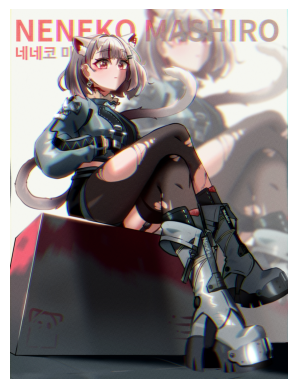

In [8]:
from PIL import Image
import matplotlib.pyplot as plt

# 이미지 불러오기 (RGBA 모드 유지)
image = Image.open("images/IMG_3925.JPG").convert("RGBA")

# 이미지 출력
plt.imshow(image)
plt.axis("off")  # 축 제거
plt.show()

In [6]:
from PIL import Image

# 이미지 불러오기 (RGBA 모드 유지)
image = Image.open("images/blocks.png").convert("RGBA")

# 자를 영역 설정 (x1, y1, x2, y2)
crop_area = (50, 50, 300, 300)  # 원하는 좌표 입력
cropped_image = image.crop(crop_area)

# 결과 저장 (PNG 형식 유지)
cropped_image.save("output.png", format="PNG")


In [3]:
import cv2

t = cv2.imread("test.png", cv2.IMREAD_UNCHANGED)
print(t)

None
